In [41]:
# Define file paths for labels and images
label_file_path = r"/kaggle/input/expression-in-the-wild-expw-dataset/label.lst"
images_folder_path = r"/kaggle/input/origin-expw/origin/"

In [42]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import concurrent.futures
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load label data into a pandas DataFrame
df_info = pd.read_csv(label_file_path, sep=" ", header=None)
df_info.columns = ['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left', 
                   'face_box_right', 'face_box_bottom', 'face_box_confidence', 'expression_label']

# Display the first few rows of the DataFrame
df_info.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [43]:

# Check the shape of the DataFrame (number of rows and columns)
df_info.shape

(91793, 8)



Plotting class distribution of emotions.


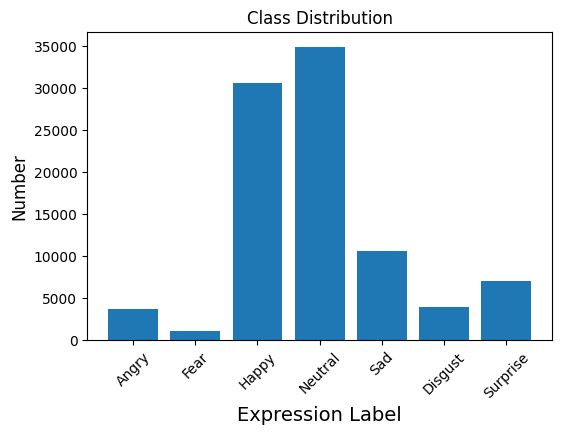

In [44]:
# Define a mapping of expression labels to human-readable emotions
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Count occurrences of each expression label
emotion_counts = df_info['expression_label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['expression_label', 'number']

# Map expression labels to emotion names
emotion_counts['expression_label'] = emotion_counts['expression_label'].map(emotion_map)

# Plot class distribution of emotions
print("\n\nPlotting class distribution of emotions.")
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.expression_label, emotion_counts.number)
plt.title('Class Distribution')
plt.xlabel('Expression Label', fontsize=14)
plt.ylabel('Number', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [45]:
# Filter out faces with confidence lower than 80
df_sel = df_info[df_info.face_box_confidence > 60]

# Function to process each image: crop the face, resize it, and return the image and label
def process_image(row):
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    y1 = row["face_box_top"]
    x2 = row["face_box_right"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_folder_path, img_name)

    # Read the image
    image = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if image is None:
        return None, None

    # Crop the face region and resize to (64, 64)
    cropped = image[y1:y2, x1:x2]
    if cropped is not None:
        resized_face = cv2.resize(cropped, (64, 64))
        return resized_face, label
    return None, None

In [46]:
# Process images in parallel using multithreading for efficiency
x = []  # To store processed images
y = []  # To store corresponding labels
def process_images_in_parallel(dataframe):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_row = {executor.submit(process_image, row): row for i, row in dataframe.sample(12000).iterrows()}
        for future in concurrent.futures.as_completed(future_to_row):
            resized_face, label = future.result()
            if resized_face is not None:
                x.append(resized_face)
                y.append(label)

# Run the image processing in parallel
process_images_in_parallel(df_sel)


In [47]:
# Convert the image and label lists into NumPy arrays for model training
X = np.array(x)
y = np.array(y)


In [48]:

# Normalize image data to range [0, 1] for better training performance
X_normalized = X / 255.0

In [49]:
# Sample 3500 images randomly from the dataset (optional step)
sample_size = 35000
random_indices = np.random.choice(len(X_normalized), size=sample_size)
X_sampled = X_normalized[random_indices]
Y_sampled = y[random_indices]

# Encode labels into numerical format (needed for classification tasks)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_sampled)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_encoded, test_size=0.2, random_state=42)

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the VGG16 layers to prevent them from being updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Add custom classification layers on top of VGG16
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # 7 output classes for the 7 emotions

# Create the final model
model = Model(inputs=vgg16.input, outputs=predictions)

# Compile the model using Adam optimizer and sparse categorical cross-entropy for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model for 10 epochs with a batch size of 32
print("\n\nTraining the model for 10 epochs with a batch size of 32")
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

# Evaluate the model on the test set and print accuracy
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test accuracy: {accuracy:.2f}")

# Train the model again and store the training history for analysis
print("\n\nTraining the model again and store the training history for analysis")

history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_test, Y_test))

# Extract training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']





Training the model for 10 epochs with a batch size of 32
Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5022 - loss: 1.3506 - val_accuracy: 0.6017 - val_loss: 1.1409
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6098 - loss: 1.0865 - val_accuracy: 0.6466 - val_loss: 0.9925
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6812 - loss: 0.8872 - val_accuracy: 0.7113 - val_loss: 0.8649
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7601 - loss: 0.6991 - val_accuracy: 0.7417 - val_loss: 0.7759
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8288 - loss: 0.5237 - val_accuracy: 0.8039 - val_loss: 0.6156
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8729 - loss: 0.3856 - val_accuracy: 0.8307 - val_loss: 0.5722
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9065 - loss: 0.2921 - val_accuracy: 0.8657 - val_loss: 0.4789
Epoch 8/10
875/875 ━━━━━━━━━━━━

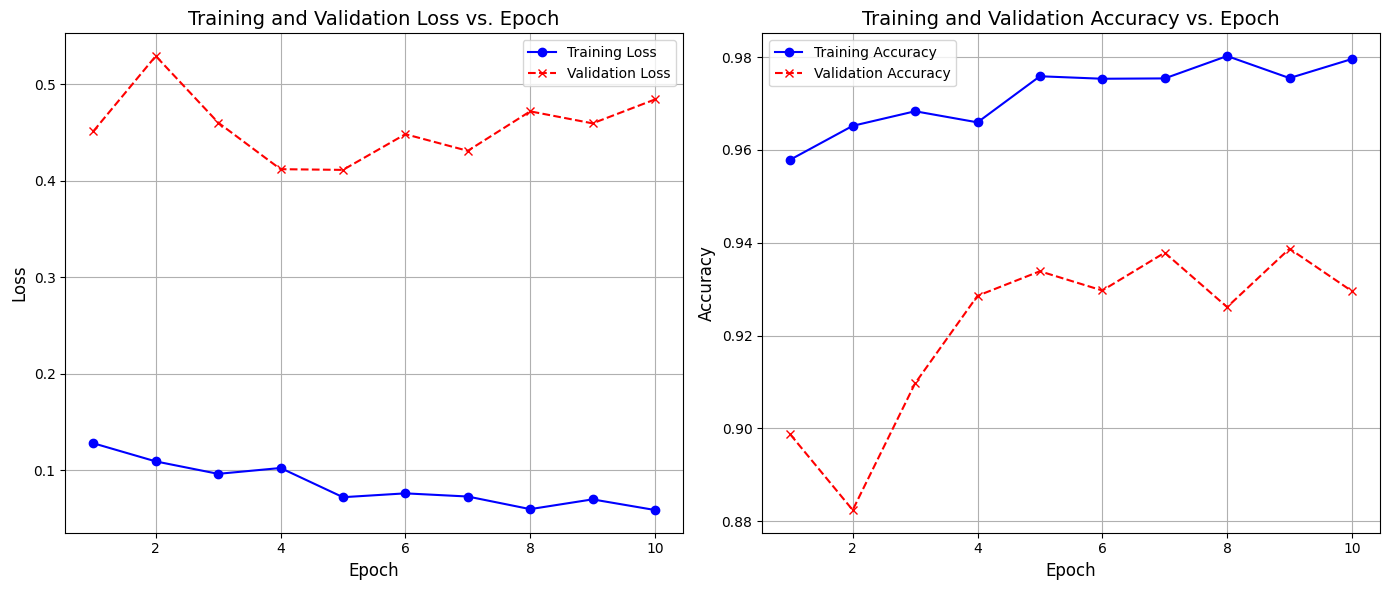

In [52]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss vs. Epoch and Training and Validation Accuracy vs. Epoch side by side


# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Training and Validation Loss
axes[0].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='b', linestyle='-', marker='o')
axes[0].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='r', linestyle='--', marker='x')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss vs. Epoch', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Plot Training and Validation Accuracy
axes[1].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='b', linestyle='-', marker='o')
axes[1].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='r', linestyle='--', marker='x')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy vs. Epoch', fontsize=14)
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



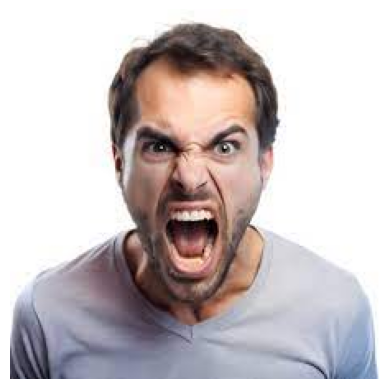

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Emotion: Angry


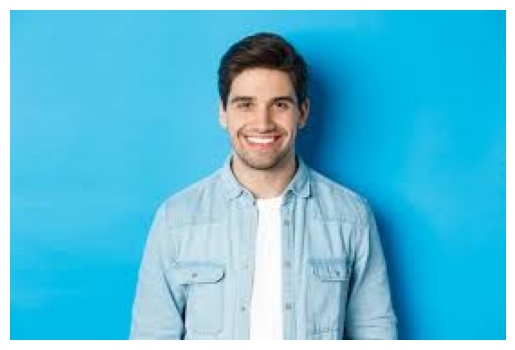

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Emotion: Happy


3

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_image(model, image_path, label_encoder):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb), plt.axis('off'), plt.show()

    image_preprocessed = np.expand_dims(cv2.resize(image_rgb, (64, 64)) / 255.0, axis=0)
    predicted_label = np.argmax(model.predict(image_preprocessed))
    
    predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]
    print(f"Predicted Emotion: {emotion_map[predicted_emotion]}")
    return predicted_emotion

# Test the function
test_image(model, '/kaggle/input/test-images/test_image4.jpeg', label_encoder)
test_image(model, '/kaggle/input/test-images/test_image.jpeg', label_encoder)

